# Importing libraries


In [1]:
## for data
import json
import pandas as pd
import numpy as np
import os
from numpy import sort

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set(rc={'figure.figsize': [10, 7]}, font_scale=1.0)

## for processing and feature engineering
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.sparse import csr_matrix,coo_matrix
from gensim.utils import simple_preprocess
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import randint as sp_randint
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

import re

## For Model
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

## For Evaluation
from sklearn.metrics import classification_report,precision_score,recall_score,accuracy_score,f1_score,roc_auc_score, confusion_matrix


C:\Users\MElBa\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Helper Functions


In [2]:
# Function to convert list into strings

def list_toString(action):
    
    "Function to convert list into strings"
    action = [ str(i) for i in action ]
    
    action = [ re.sub('nan','',i) for i in action ] 
    
    action = ' '.join(action)
    
    return action


def clean_text(row):
    ## clean (convert to lowercase and remove punctuations and characters and then strip,convert from string to list)
    lst_text = simple_preprocess(row)
   
    ## back to string from list
    text = " ".join(lst_text)
    return text

# Get the data

In [3]:
# Let us load the data now.
DATA_PATH="./dataset/"
leads=pd.read_csv(DATA_PATH+"leads_v2.csv",low_memory=False)
leads.sample(10)

,lead_id,customer_name,lead_mobile_network,message,lead_time,method_of_contact,ad_group,lead_source,campaign,location,low_qualified,lead_time_year,lead_time_month,lead_time_day,lead_time_dow,lead_time_hour,lead_time_date
25351,39708,Mahmoud Aboutalib,Vodafone,NaN,2021-07-21 00:14:14.760000,facebook,marassi general audience with real estate inte...,facebook,emaar lead generation cooing 3,marassi,0,2021,7,21,Wednesday,0,2021-07-21
11785,27275,Mona Latif,Orange,NaN,2020-09-26 18:52:28.921000,form,unkown,google,google cpc,il monte galala ain sokhna,0,2020,9,26,Saturday,18,2020-09-26
49226,63742,Sameh Rashad,Orange,NaN,2021-12-17 13:57:06.751259,facebook,unkown,facebook,unknown,cairo gate emaar west - 6th of october,0,2021,12,17,Friday,13,2021-12-17
35492,51730,Germaine Aboud,Orange,NaN,2021-09-12 15:48:50.531948,facebook,zed east cib aibk creme gouna congrats lookalike,facebook,ora developers lead generation cooing 1,zed east,0,2021,9,12,Sunday,15,2021-09-12
34653,50698,Fadia,Others,NaN,2021-09-06 12:21:07.347863,phone,unkown,phone,unknown,unknown,0,2021,9,6,Monday,12,2021-09-06
32229,48499,Ahmed,Vodafone,NaN,2021-08-23 00:15:02.176690,app,unkown,app,unknown,unknown,0,2021,8,23,Monday,0,2021-08-23
29923,46460,Amira Osama,Orange,NaN,2021-08-10 20:13:27.853000,app,unkown,landing page,unknown,mountain view icity new cairo,0,2021,8,10,Tuesday,20,2021-08-10
45775,60757,Ahmed Adel,Vodafone,NaN,2021-11-27 16:55:32.950687,facebook,keeva general audience with real estate interests,facebook,al ahly sabbour developments lead generation c...,keeva,1,2021,11,27,Saturday,16,2021-11-27
12198,27691,Hala Anan,Vodafone,NaN,2020-10-17 10:30:39.120000,facebook,sodic east aibk lookalike,facebook,sodic lead generation,sodic east,0,2020,10,17,Saturday,10,2020-10-17
26790,41037,Mohamed Hossam Yehia,Vodafone,NaN,2021-07-27 02:11:20.066000,facebook,marassi cib lookalike,facebook,emaar misr lead generation new,marassi,1,2021,7,27,Tuesday,2,2021-07-27


# Prepare the Data & Feature Engineering


In [4]:
leadsCounts=pd.DataFrame(leads.lead_id.value_counts()).reset_index().rename(columns={'index':"lead_id","lead_id":"TotalVisits"})
leadsCounts.head()

,lead_id,TotalVisits
0,31069,57
1,57328,46
2,61131,44
3,1116,39
4,76915,37


In [5]:
locations = leads.groupby('lead_id', as_index=False)['location'].agg(lambda x: x.tolist())
locations['location'] = locations['location'].apply(list_toString)
locations.head()

,lead_id,location
0,22,sodic october plaza
1,30,o west
2,42,el gouna for sale & resale
3,44,north edge
4,48,joulz


In [6]:
ad_groups = leads.groupby('lead_id', as_index=False)['ad_group'].agg(lambda x: x.tolist())
ad_groups['ad_group'] = ad_groups['ad_group'].apply(list_toString)

ad_groups.head()

,lead_id,ad_group
0,22,unkown
1,30,o west fb creme de la creme cairo giza 27 60
2,42,gouna properties
3,44,new release north edge general with north coas...
4,48,unkown


In [7]:
campaigns = leads.groupby('lead_id', as_index=False)['campaign'].agg(lambda x: x.tolist())
campaigns['campaign'] = campaigns['campaign'].apply(list_toString)

campaigns.head()

,lead_id,campaign
0,22,dev sodic
1,30,orascom lead generation
2,42,locations
3,44,city edge lead generation
4,48,dev inertia egypt


In [8]:
campaigns['campaing_ad_group_loc']=campaigns['campaign']+" "+ad_groups['ad_group']+" "+locations['location']

In [9]:
df=campaigns.drop(columns='campaign')

In [10]:
temp=df.merge(leadsCounts,on='lead_id')

In [11]:
temp.sample(10)

,lead_id,campaing_ad_group_loc,TotalVisits
46159,72290,dev inertia egypt ar unkown joulz,1
49356,76206,unknown unkown address east by dorra,1
67035,97275,misr italia lead generation cooing 1 new il bo...,1
64683,94423,dev shahawi group عين هيلز العين السخنة,1
18460,37609,palm hills lead generation cooing 3 hacienda w...,1
16454,35333,unknown unkown capital garden,1
36901,61775,dev emaar ar unkown marassi,1
20734,40189,developer x lead generation cooing 3 bianchi i...,1
10129,28043,unknown unkown new giza,1
2985,19954,google cpc unkown waterside el gouna,1


In [12]:
leads=leads.drop(columns=[ 'campaign', 'location', 'ad_group'])

In [13]:
leads=leads.drop_duplicates(subset='lead_id')

In [14]:
leads=leads.merge(temp,on='lead_id').drop(columns=['lead_id','customer_name','message','lead_time','lead_time_date','lead_time_day'])

In [15]:
leads.sample(5)

,lead_mobile_network,method_of_contact,lead_source,low_qualified,lead_time_year,lead_time_month,lead_time_dow,lead_time_hour,campaing_ad_group_loc,TotalVisits
43630,Vodafone,facebook,facebook,0,2022,2,Tuesday,5,edge holding lead generation cooing 3 unknown ...,2
20013,Orange,facebook,facebook,0,2021,7,Monday,6,inertia lead generation cooing 4 jefaira gouna...,1
20147,Vodafone,facebook,facebook,0,2021,7,Tuesday,0,emaar lead generation cooing 3 marassi villas ...,1
42418,Vodafone,facebook,facebook,0,2022,1,Saturday,22,sodic lead generation new cooing 2 sky condos ...,1
39045,Etisalat,facebook,facebook,0,2021,12,Monday,12,madinet nasr for housing and development lead ...,1


In [16]:
cols=['lead_mobile_network', 'method_of_contact', 'lead_source', 'lead_time_year', 'lead_time_month', 'lead_time_dow', 'lead_time_hour' ]
for i in cols:
    leads[i]=leads[i].astype("category")

In [17]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70017 entries, 0 to 70016
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   lead_mobile_network    70017 non-null  category
 1   method_of_contact      70017 non-null  category
 2   lead_source            70017 non-null  category
 3   low_qualified          70017 non-null  int64   
 4   lead_time_year         70017 non-null  category
 5   lead_time_month        70017 non-null  category
 6   lead_time_dow          70017 non-null  category
 7   lead_time_hour         70017 non-null  category
 8   campaing_ad_group_loc  70017 non-null  object  
 9   TotalVisits            70017 non-null  int64   
dtypes: category(7), int64(2), object(1)
memory usage: 2.6+ MB


### Working with campaing ad group location as text to try to find pattern

In [18]:
leads["campaing_ad_group_loc"]=leads["campaing_ad_group_loc"].apply(lambda x: clean_text(x))
vectorizer= TfidfVectorizer(sublinear_tf=True, min_df=10, encoding='latin-1', ngram_range=(1,1))
Tfidf=vectorizer.fit_transform(leads["campaing_ad_group_loc"])
Tfidf=pd.DataFrame(Tfidf.toarray(),columns=np.array(vectorizer.get_feature_names_out()))
Tfidf.head()

,ab,abroad,abu,abudahbi,account,ad,adcg,address,ads,adset,aeon,ahly,aibk,ain,ajna,akam,al,alamein,alburoujsms,alcamar,alex,alexandria,alike,alkarma,all,allam,allegria,almorshedy,amany,amazon,ancient,and,android,androids,apartment,apartment_cb,apartments,api,apple,ar,arabella,arabia,arabian,arabic,area,aria,arkan,armonia,aster,atika,attal,audiencde,audience,aura,australia,auto,avenir,avenues,axis,ayla,azad,azha,azzar,badreldin,badya,badyasms,based,bay,baymount,beach,bedroom,bedrooms,beds,belle,better,bianch,bianchi,bleu,blocked,bloomfields,blue,blueviews,bo,borouj,bosco,brand,branded,brooks,brouj,burouj,business,buyers,buying,by,ca,caesar,cairene,cairo,cairogateemail,cairogatesms,cali,call,camellia,campaign,campaigns,canal,capital,capitalway,carnelia,carnell,cars,casa,cascada,castle,cavana,celia,center,central,cfc,chalet,chalets,chill,chillout,cib,city,cityscape,cj,cjwkcajw,cleo,cleopatra,clients,cliff,clinics,club,clubside,coast,cograts,cold,com,commercial,community,complex,compound,compounds,condo,condos,congrats,contact,conversions,cooing,cooingestate,copy,cornerstone,countries,cpa,cpc,creative,cred,creek,creeks,creektown,creme,cribs,crown,curve,custom,cyan,dae,days,dbay,de,december,dejoya,detailed,dev,dev_,developer,developers,development,developments,devices,dhabi,di,diamond,direction,discover,display,district,dorra,downtown,dubai,dunes,duplex,dynamic,east,eastown,edge,edris,education,eg,egypt,egyptair,egyptian,eight,ein,el,elgouna,elsheikh,emaar,email,england,english,eoi,equity,estate,estates,etapa,eu,ever,evia,exc,exclude,expansion,extension,ezan,facebook,fajr,false,fanadir,faya,fergany,festival,ficing,fifth,filtered,first,for,form,forms,fouka,frequent,from,furl,futtaim,gaia,galala,galleria,garden,gardens,gate,...,sale,sands,sarai,saudi,sawari,sawiris,scape,scarlet,scenario,sea,search,seashell,secon,selected,selina,sellmyproperty,serviced,set,settlement,shahawi,shedwan,sheikh,sherouk,shorouk,sidi,sila,silversands,sixty,skaia,skala,sky,smeralda,sms,sodic,sokhna,soma,somabay,soul,specific,spent,square,standalone,starlight,stei,stella,stone,strip,studio,stunning,sueno,summer,sun,super,swan,swanlake,taj,tameer,target,targeting,tatweer,tawila,tawny,telal,test,testing,th,than,the,thegiselle,thoctober,three,time,times,tmg,top,topaz,tower,towers,town,townhouse,traffic,traveler,travelers,travellers,trevi,trial,trict,trio,twinhouse,type,typical,uc,unit,unit_area,unitower,unknown,unkown,updated,uptown,urbnlanes,us,utm_adgroup,utm_campaign,vacation,vert,vida,video,vie,view,views,villa,village,villas,ville,villette,vinci,visitors,vista,vs,vues,vye,wadi,walk,water,waterside,waterway,wave,way,website,west,western,westown,white,with,www,yards,zahra,zahraa,zahya,zayed,zed,zeina,zia,zoya,أدريس,أكتوبر,أوت,أي,إيست,ارابيلا,اكتوبر,الإدارية,الادارية,الايقوني,البرج,البروج,التجمع,التسعين,التشطيب,الجديدة,الحكمة,الخامس,الساحل,السخنة,السكني,الشمالي,الشيخ,العاصمة,العلمين,العمراني,العين,القاهرة,الكمار,المقصد,او,اوربن,اي,ايست,ايفر,بادية,بارك,بالعاصمة,بالم,باي,بمدينة,بيراميدز,بيزنس,تاج,تاور,تشطيب,تشيل,توباز,جاردنز,جديدة,جروب,جرين,جيت,حشيش,دايركشن,دره,ذا,راس,ريزيدنس,زايد,زهرة,زيد,ساندز,ستون,سهل,سيتي,سيلفر,سيناريو,شارع,شقق,صن,صواري,طلعت,عين,فندق,في,فيستا,فينشي,فيو,كابيتال,كاسيل,كاملة,كايرو,كبموند,كريد,كمبوند,لا,لافيستا,لاندمارك,للتطوير,لوفت,ليفيلز,لينز,ماسبيرو,ماونتن,مثلث,مدينتي,مراسي,مرحلة,مصطفى,من,مول,هيلز,واحد,وايت,ويست
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [19]:
dropList = ['low_qualified','campaing_ad_group_loc','TotalVisits']
ohe=OneHotEncoder()

In [20]:
df_ohe=ohe.fit_transform(leads.drop(columns=dropList)).toarray()

In [21]:
df_ohe=pd.DataFrame(df_ohe,columns=np.array(ohe.get_feature_names_out()))


In [22]:
df_ohe.head()

,lead_mobile_network_Etisalat,lead_mobile_network_Europe,lead_mobile_network_Gulf,lead_mobile_network_Orange,lead_mobile_network_Others,lead_mobile_network_US_Canda,lead_mobile_network_Vodafone,lead_mobile_network_WE,method_of_contact_app,method_of_contact_facebook,method_of_contact_form,method_of_contact_google,method_of_contact_other,method_of_contact_phone,method_of_contact_referral,method_of_contact_website,lead_source_app,lead_source_facebook,lead_source_form,lead_source_google,lead_source_landing page,lead_source_other,lead_source_phone,lead_source_referral,lead_source_unknown,lead_source_website,lead_time_year_2019,lead_time_year_2020,lead_time_year_2021,lead_time_year_2022,lead_time_month_1,lead_time_month_2,lead_time_month_3,lead_time_month_4,lead_time_month_5,lead_time_month_6,lead_time_month_7,lead_time_month_8,lead_time_month_9,lead_time_month_10,lead_time_month_11,lead_time_month_12,lead_time_dow_Friday,lead_time_dow_Monday,lead_time_dow_Saturday,lead_time_dow_Sunday,lead_time_dow_Thursday,lead_time_dow_Tuesday,lead_time_dow_Wednesday,lead_time_hour_0,lead_time_hour_1,lead_time_hour_2,lead_time_hour_3,lead_time_hour_4,lead_time_hour_5,lead_time_hour_6,lead_time_hour_7,lead_time_hour_8,lead_time_hour_9,lead_time_hour_10,lead_time_hour_11,lead_time_hour_12,lead_time_hour_13,lead_time_hour_14,lead_time_hour_15,lead_time_hour_16,lead_time_hour_17,lead_time_hour_18,lead_time_hour_19,lead_time_hour_20,lead_time_hour_21,lead_time_hour_22,lead_time_hour_23
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
leads=pd.concat([Tfidf,df_ohe,leads[['low_qualified','TotalVisits']]],axis=1)


In [24]:
leads.shape

(70017, 865)

# Splitting train and test

In [25]:
y_train = leads['low_qualified']
x_train=leads.drop(columns=['low_qualified'])


In [26]:
## handling imbalanced data
from imblearn.under_sampling import RandomUnderSampler
Undersample = NearMiss(version=3, n_neighbors_ver3=3)
X_trainUndersample, y_trainUndersample = Undersample.fit_resample(x_train, y_train)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_trainUndersample, y_trainUndersample, train_size=0.8, stratify=y_trainUndersample,random_state=42)

# Model Selection & Evaluation Metric

I choose **recall** as an Evaluation metric because we care more about not miss classifying high-qualified leads as low-qualified **False Positives**, we will use metric recall as a guidance that our model works well **business-wise**.

#### W/ Undersampling approach

## Decision Tree

In [28]:
DT = DecisionTreeClassifier(random_state=42)
DT.fit(X_train, y_train)

y_predDT_train = DT.predict(X_train)  
print("classification report:\n\n",classification_report(y_train, y_predDT_train)) 
print("="*50)
y_predDT_test = DT.predict(X_test)  


print("classification report:\n\n",classification_report(y_test, y_predDT_test)) 


classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8692
           1       1.00      1.00      1.00      8692

    accuracy                           1.00     17384
   macro avg       1.00      1.00      1.00     17384
weighted avg       1.00      1.00      1.00     17384

classification report:

               precision    recall  f1-score   support

           0       0.63      0.62      0.62      2173
           1       0.62      0.63      0.63      2173

    accuracy                           0.62      4346
   macro avg       0.62      0.62      0.62      4346
weighted avg       0.62      0.62      0.62      4346



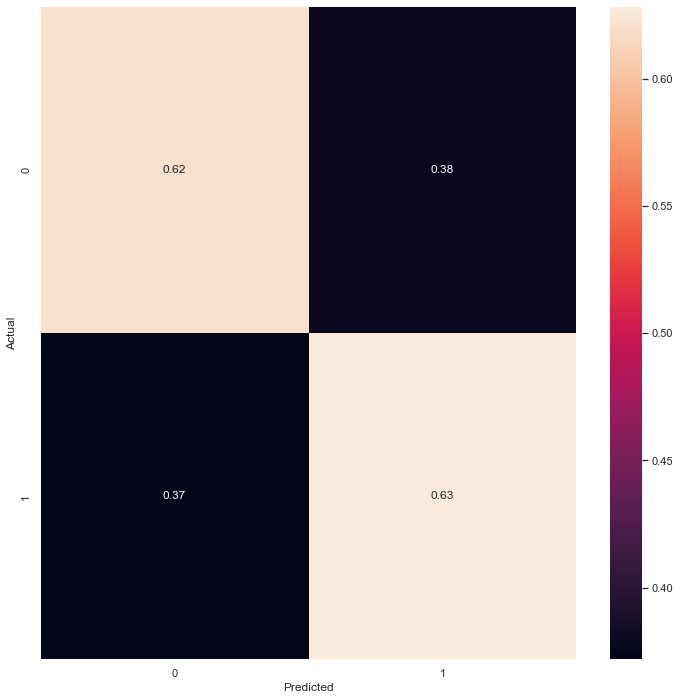

In [29]:
conf_mat = confusion_matrix(y_test, y_predDT_test,normalize='true')
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True,xticklabels=list(leads['low_qualified'].unique()),yticklabels=list(leads['low_qualified'].unique()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Random Forest


In [30]:
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)

y_predDT_train = RF.predict(X_train)  
print("classification report:\n\n",classification_report(y_train, y_predDT_train)) 
print("="*50)
y_predDT_test = RF.predict(X_test)  


print("classification report:\n\n",classification_report(y_test, y_predDT_test)) 


classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8692
           1       1.00      1.00      1.00      8692

    accuracy                           1.00     17384
   macro avg       1.00      1.00      1.00     17384
weighted avg       1.00      1.00      1.00     17384

classification report:

               precision    recall  f1-score   support

           0       0.65      0.72      0.68      2173
           1       0.69      0.61      0.65      2173

    accuracy                           0.67      4346
   macro avg       0.67      0.67      0.67      4346
weighted avg       0.67      0.67      0.67      4346



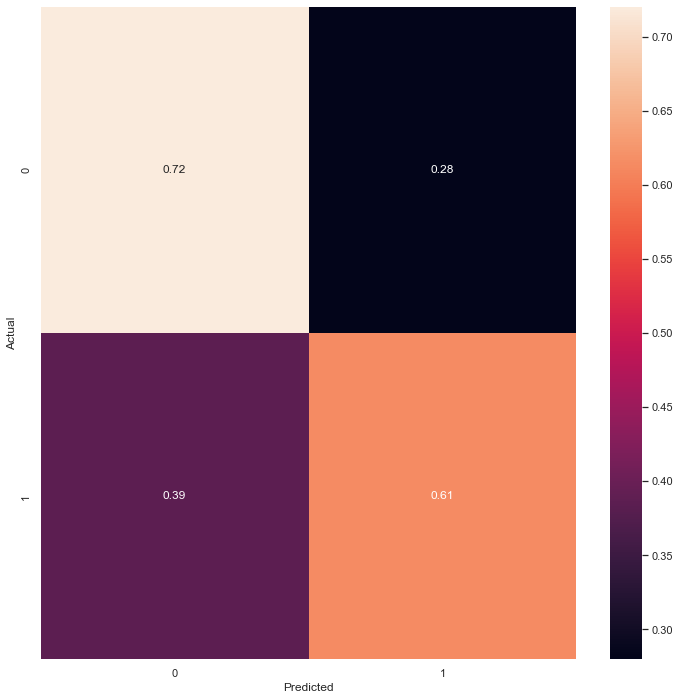

In [31]:
conf_mat = confusion_matrix(y_test, y_predDT_test,normalize='true')
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True,xticklabels=list(leads['low_qualified'].unique()),yticklabels=list(leads['low_qualified'].unique()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# XGBoost  Classifier

In [32]:
XGB = XGBClassifier(use_label_encoder=False,eval_metric='mlogloss',random_state=42)
XGB.fit(X_train, y_train)


y_predDT_train = XGB.predict(X_train)  
print("classification_report:\n\n",classification_report(y_train, y_predDT_train)) 
print("="*50)
y_predDT_test = XGB.predict(X_test)  


print("classification_report:\n\n",classification_report(y_test, y_predDT_test)) 


C:\Users\MElBa\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


classification_report:

               precision    recall  f1-score   support

           0       0.73      0.83      0.78      8692
           1       0.80      0.69      0.74      8692

    accuracy                           0.76     17384
   macro avg       0.77      0.76      0.76     17384
weighted avg       0.77      0.76      0.76     17384

classification_report:

               precision    recall  f1-score   support

           0       0.65      0.74      0.69      2173
           1       0.70      0.60      0.64      2173

    accuracy                           0.67      4346
   macro avg       0.67      0.67      0.67      4346
weighted avg       0.67      0.67      0.67      4346



C:\Users\MElBa\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


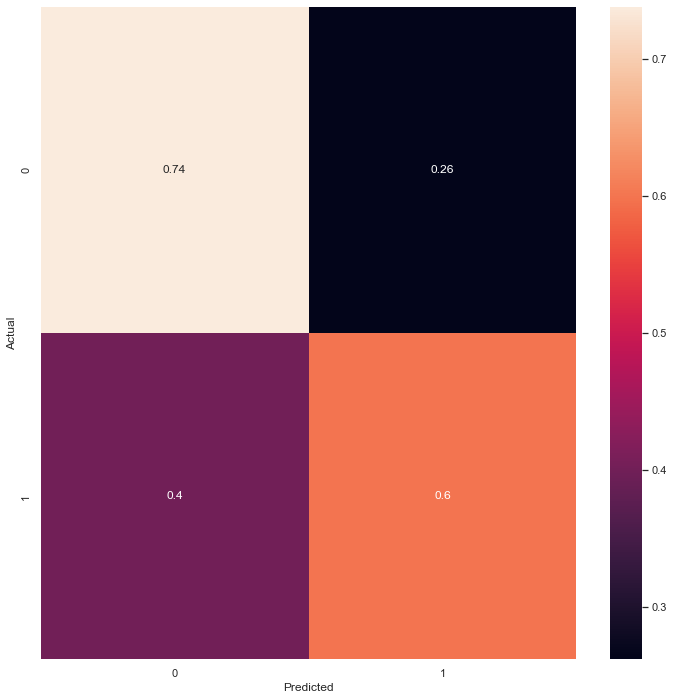

In [33]:
conf_mat = confusion_matrix(y_test, y_predDT_test,normalize='true')
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True,xticklabels=list(leads['low_qualified'].unique()),yticklabels=list(leads['low_qualified'].unique()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### W/ Oversampling approach

In [34]:
y_train = leads['low_qualified']
x_train=leads.drop(columns=['low_qualified'])

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.8, stratify=y_train,random_state=42)

In [35]:
OverSampling=SMOTE(sampling_strategy='minority')
X_train, y_train = OverSampling.fit_resample(X_train, y_train)

In [36]:
y_train.value_counts()

0    47321
1    47321
Name: low_qualified, dtype: int64

In [37]:
DT = DecisionTreeClassifier(random_state=42)
DT.fit(X_train, y_train)

y_predDT_train = DT.predict(X_train)  
print("classification report:\n\n",classification_report(y_train, y_predDT_train)) 
print("="*50)
y_predDT_test = DT.predict(X_test)  


print("classification report:\n\n",classification_report(y_test, y_predDT_test)) 


classification report:

               precision    recall  f1-score   support

           0       0.99      1.00      0.99     47321
           1       1.00      0.99      0.99     47321

    accuracy                           0.99     94642
   macro avg       0.99      0.99      0.99     94642
weighted avg       0.99      0.99      0.99     94642

classification report:

               precision    recall  f1-score   support

           0       0.87      0.86      0.86     11831
           1       0.27      0.28      0.27      2173

    accuracy                           0.77     14004
   macro avg       0.57      0.57      0.57     14004
weighted avg       0.77      0.77      0.77     14004



In [38]:
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)

y_predDT_train = RF.predict(X_train)  
print("classification report:\n\n",classification_report(y_train, y_predDT_train)) 
print("="*50)
y_predDT_test = RF.predict(X_test)  


print("classification report:\n\n",classification_report(y_test, y_predDT_test)) 


classification report:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99     47321
           1       0.99      0.99      0.99     47321

    accuracy                           0.99     94642
   macro avg       0.99      0.99      0.99     94642
weighted avg       0.99      0.99      0.99     94642

classification report:

               precision    recall  f1-score   support

           0       0.86      0.94      0.90     11831
           1       0.36      0.19      0.25      2173

    accuracy                           0.82     14004
   macro avg       0.61      0.56      0.57     14004
weighted avg       0.78      0.82      0.80     14004



In [39]:
XGB = XGBClassifier(use_label_encoder=False,eval_metric='mlogloss',random_state=42)
XGB.fit(X_train, y_train)


y_predDT_train = XGB.predict(X_train)  
print("classification_report:\n\n",classification_report(y_train, y_predDT_train)) 
print("="*50)
y_predDT_test = XGB.predict(X_test)  


print("classification_report:\n\n",classification_report(y_test, y_predDT_test)) 


C:\Users\MElBa\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


classification_report:

               precision    recall  f1-score   support

           0       0.86      0.99      0.92     47321
           1       0.99      0.84      0.91     47321

    accuracy                           0.91     94642
   macro avg       0.92      0.91      0.91     94642
weighted avg       0.92      0.91      0.91     94642

classification_report:

               precision    recall  f1-score   support

           0       0.85      0.98      0.91     11831
           1       0.48      0.09      0.15      2173

    accuracy                           0.84     14004
   macro avg       0.67      0.54      0.53     14004
weighted avg       0.80      0.84      0.80     14004



C:\Users\MElBa\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


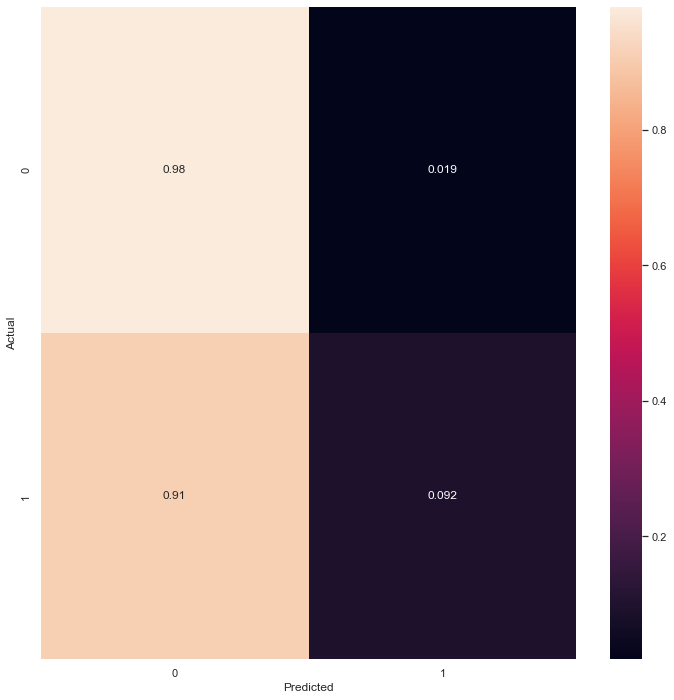

In [40]:
conf_mat = confusion_matrix(y_test, y_predDT_test,normalize='true')
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True,xticklabels=list(leads['low_qualified'].unique()),yticklabels=list(leads['low_qualified'].unique()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### So, we chose Xgboost as our model due to the highest score and did not tend to overfit Random Forest and Decision tree

## And undersampling approach more better with two classes, and we focus more with reducing false postive for high qualified.

In [41]:
y_train = leads['low_qualified']
x_train=leads.drop(columns=['low_qualified'])

## handling imbalanced data
Undersample = NearMiss(version=3, n_neighbors_ver3=3)
X_trainUndersample, y_trainUndersample = Undersample.fit_resample(x_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X_trainUndersample, y_trainUndersample, train_size=0.8, stratify=y_trainUndersample,random_state=42)
# XGB = XGBClassifier(use_label_encoder=False,eval_metric='mlogloss',random_state=42)
# XGB.fit(X_train, y_train)


### Features Selection

In [42]:
# from sklearn.feature_selection import SelectFromModel

# FeatureImp=SelectFromModel(estimator=XGB,max_features=None,prefit=True)
# x_train_imp=FeatureImp.transform(X_train)
# x_text_imp=FeatureImp.transform(X_test)

# x_train_imp.shape

## Our Final Model

In [43]:
param = {
'max_depth': sp_randint(3, 20),
'learning_rate': [0.001, 0.01, 0.1, 0.2],
'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
'min_child_weight': [0.25,0.5, 1.0, 3.0, 5.0, 7.0],
'gamma': [0, 0.25, 0.3,0.35,0.45,0.5,0.6,0.8,1.0],
'reg_lambda': [0.1,0.2,0.4,0.5,0.6,0.8,1.0,10.0],
'n_estimators':[100,200,500,1000,2000],
'colsample_bytree':[0.1,0.3,0.5,1],
'colsample_bylevel':[0.1,0.3,0.5,1]
}


XGB = XGBClassifier(objective='binary:logistic',eval_metric='mlogloss',use_label_encoder=False)

clf = RandomizedSearchCV(XGB, param,n_jobs=-1,verbose=10,scoring=f1_score, random_state=42)

In [45]:
clf.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\MElBa\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\MElBa\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           mo...
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                 

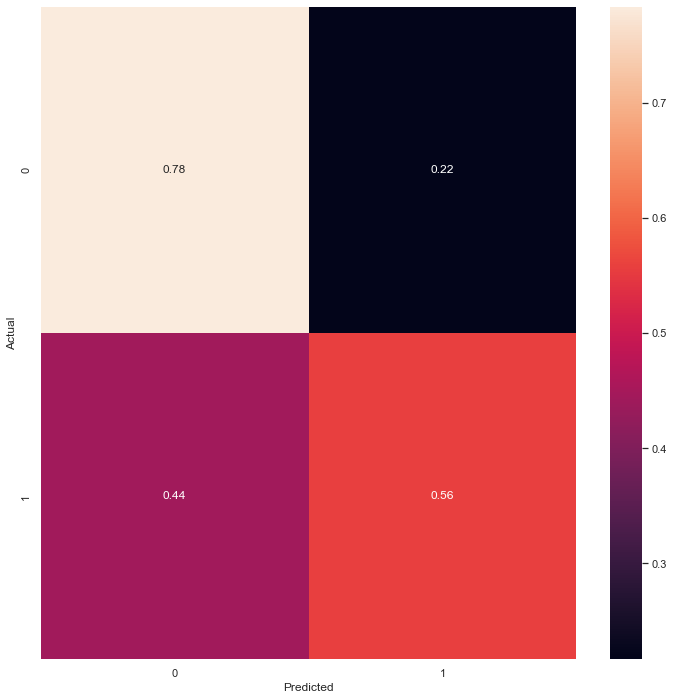

In [50]:
y_pred=clf.predict(X_test) 

conf_mat = confusion_matrix(y_test, y_pred,normalize='true')
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True,xticklabels=list(leads['low_qualified'].unique()),yticklabels=list(leads['low_qualified'].unique()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [46]:
clf.best_params_

{'colsample_bylevel': 0.5,
 'colsample_bytree': 1,
 'gamma': 0.8,
 'learning_rate': 0.001,
 'max_depth': 9,
 'min_child_weight': 0.5,
 'n_estimators': 500,
 'reg_lambda': 1.0,
 'subsample': 0.7}

## Train on whole Data

In [51]:
XGB=XGBClassifier(objective='binary:logistic',eval_metric= 'mlogloss',use_label_encoder=False,colsample_bylevel= 0.5,
                  colsample_bytree= 1,gamma=0.8,learning_rate= 0.001,max_depth= 9,min_child_weight= 0.5,
                 n_estimators= 500,reg_lambda= 1.0,subsample=0.7)
XGB.fit(X_train,y_train)


C:\Users\MElBa\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0.8, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=9,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1.0,
              scale_pos_weight=1, subsample=0.7, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)


## Select Importance features


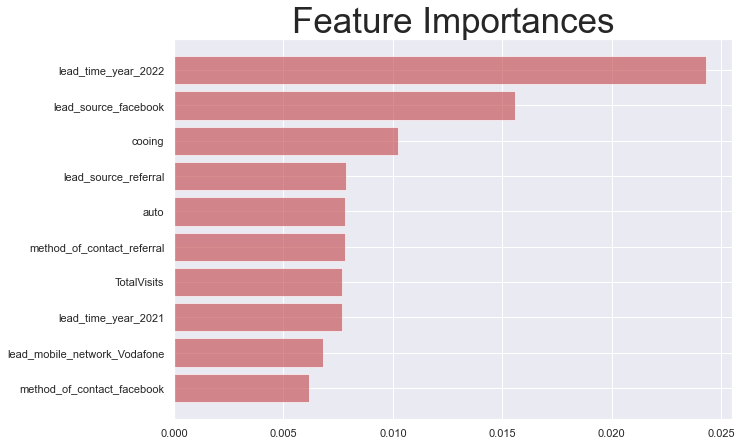

In [52]:
features =X_train.columns
importances = XGB.feature_importances_
indices = (np.argsort(importances))[-10:]
plt.figure(figsize=(10,7))
plt.title('Feature Importances',fontsize=35)
plt.barh(range(len(indices)), importances[indices], color='r', align='center',alpha=.65)
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()



In [53]:
from sklearn.feature_selection import SelectFromModel

FeatureImp=SelectFromModel(estimator=XGB,max_features=None,prefit=True)

In [66]:
x_train_imp.shape

(17384, 383)

In [59]:
x_train_imp=FeatureImp.transform(X_train)
XGB_imp=XGBClassifier(objective='binary:logistic',eval_metric= 'mlogloss',use_label_encoder=False,colsample_bylevel= 0.5,colsample_bytree= 1,gamma=0.8,learning_rate= 0.001,max_depth= 9,min_child_weight= 0.5,
                 n_estimators= 500,reg_lambda= 1.0,subsample=0.7)
XGB_imp.fit(x_train_imp,y_train)


C:\Users\MElBa\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0.8, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=9,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1.0,
              scale_pos_weight=1, subsample=0.7, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [60]:
test_df_imp=FeatureImp.transform(X_test)
y_pred_imp=XGB_imp.predict(test_df_imp)


C:\Users\MElBa\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


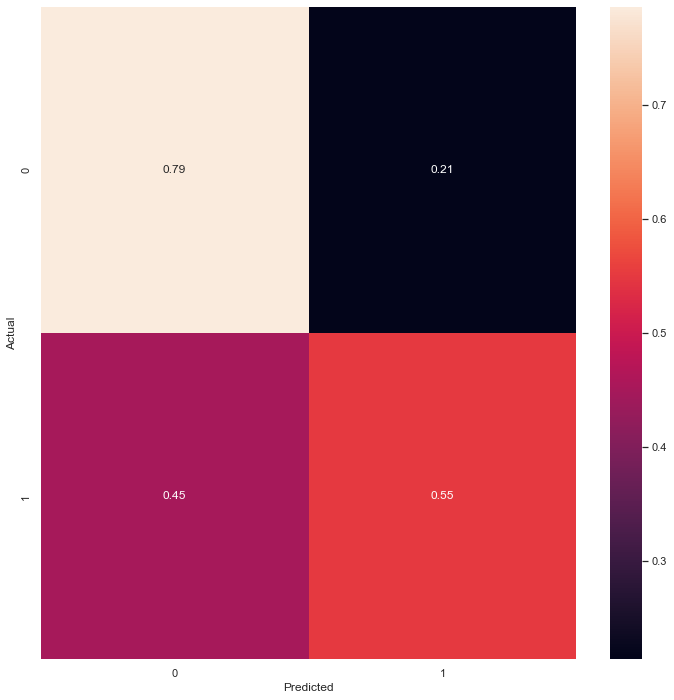

In [62]:

conf_mat = confusion_matrix(y_test, y_pred_imp,normalize='true')
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True,xticklabels=list(leads['low_qualified'].unique()),yticklabels=list(leads['low_qualified'].unique()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

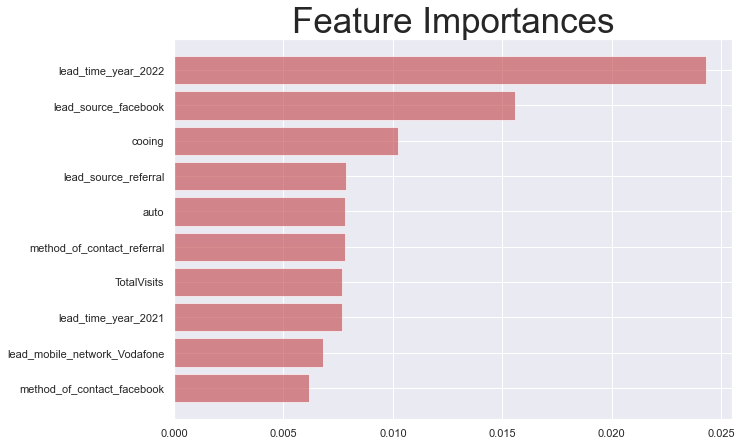

In [63]:
features =X_train.columns
importances = XGB.feature_importances_
indices = (np.argsort(importances))[-10:]
plt.figure(figsize=(10,7))
plt.title('Feature Importances',fontsize=35)
plt.barh(range(len(indices)), importances[indices], color='r', align='center',alpha=.65)
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()



In [65]:
import pickle
pickle.dump(XGB_imp, open('model.pkl', 'wb'))
with open("encoder", "wb") as f: 
    pickle.dump(ohe, f)
with open("vectorizer", "wb") as f: 
    pickle.dump(vectorizer, f)
    
    

with open("FeatureImp", "wb") as f: 
    pickle.dump(FeatureImp, f)